In [9]:
%matplotlib inline

In [1]:
#path = "data/dogscats/"
path = "data/dogscats/sample/"

In [2]:
from __future__ import division, print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [3]:
import utils; reload(utils)
from utils import plots

Using Theano backend.


In [4]:
import vgg16; reload(vgg16)
from vgg16 import Vgg16

Use Vgg16 for basic image recognition

In [5]:
vgg = Vgg16()

In [6]:
batches = vgg.get_batches(path+'train', batch_size=4)

Found 160 images belonging to 2 classes.


In [7]:
imgs, labels = next(batches)

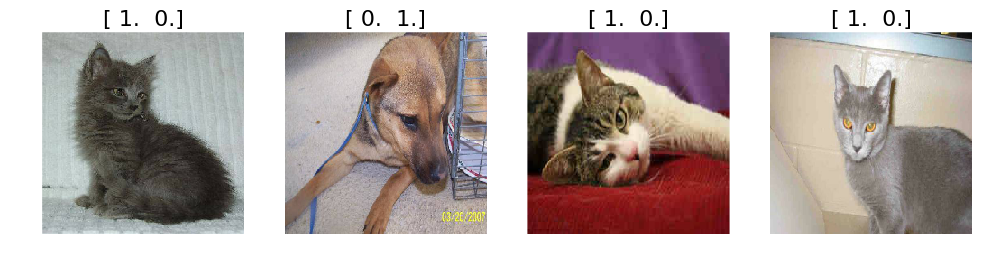

In [10]:
plots(imgs, titles=labels)

In [11]:
vgg.predict(imgs, True)

(array([ 0.2241,  0.5507,  0.3902,  0.3832], dtype=float32),
 array([283, 235, 281, 285]),
 [u'Persian_cat', u'German_shepherd', u'tabby', u'Egyptian_cat'])

In [12]:
vgg.classes[:4]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark']

## Create a VGG model from scratch in Keras

In [14]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [17]:
FILES_PATH = 'http://www.platform'; CLASS_FILE='imagenet_class_index.json'
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f:
    class_dict = json.load(f)

classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [18]:
classes[:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

model creation

In [19]:
def ConvBlock(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))


In [20]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))


In [26]:
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1]

In [27]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)
    
    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [59]:
model = VGG_16()

In [60]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

In [61]:
batch_size = 4

In [37]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224),
                                  class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


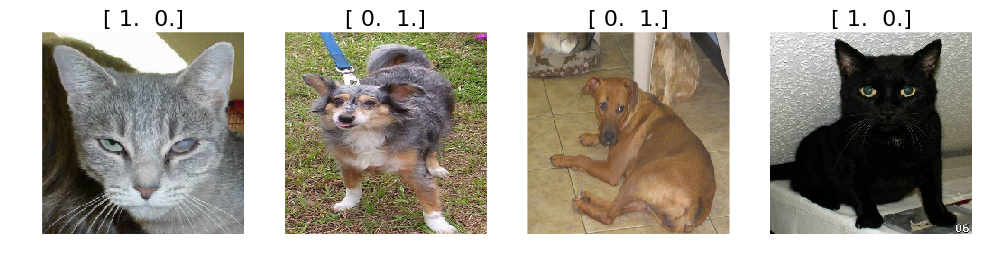

In [39]:
batches = get_batches('train', batch_size=batch_size)
val_batched = get_batches('valid', batch_size=batch_size)
imgs, labels = next(batches)

plots(imgs, titles=labels)

In [62]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)
    
    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [63]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  2.9008e-06   5.8183e-06   4.9706e-06   1.4999e-05   9.9369e-06]

Predictions prob/class: 
  0.5715/Egyptian_cat
  0.6985/Pembroke
  0.5559/Rhodesian_ridgeback
  0.3824/Egyptian_cat
